In [5]:
%run init_notebook.py
from settings import DATA_DIR

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from scipy.stats import normaltest
import scipy

In [7]:
from src.utils import *

In [8]:
# load data

In [9]:
cpi = get_dt_index(load_pd_df('cpi.csv'), 'Unnamed: 0')

In [10]:
# train test split

In [11]:
t = cpi.index.dropna().date
cpi['t'] = np.array((t - t.min()) / (t.max() - t.min()))

_train = cpi.dropna().loc[datetime(2010,1,1):datetime(2020,3,1)].copy()
_test = cpi.dropna().loc[datetime(2020,3,1):].copy()

t, y = _train['t'].values.astype(float), _train['pi_de'].values.astype(float)
t_test, y_test = _test['t'].values.astype(float), _test['pi_de'].values.astype(float)
t_all, y_all = np.concatenate([t, t_test]), np.concatenate([y, y_test])

In [12]:
# model linear

In [22]:
with pm.Model() as linear:
    alpha = pm.Normal("alpha", mu=0, sigma=0.1)
    beta = pm.Normal("beta", mu=0, sigma=0.25)
    sigma = pm.HalfNormal("sigma", sigma=0.05)
    
    trend = pm.Deterministic("trend", alpha + t * beta)

    pm.Normal("likelihood", mu=trend, sigma=sigma, observed=y)

    linear_prior_predictive = pm.sample_prior_predictive(samples=100)

Sampling: [alpha, beta, likelihood, sigma]


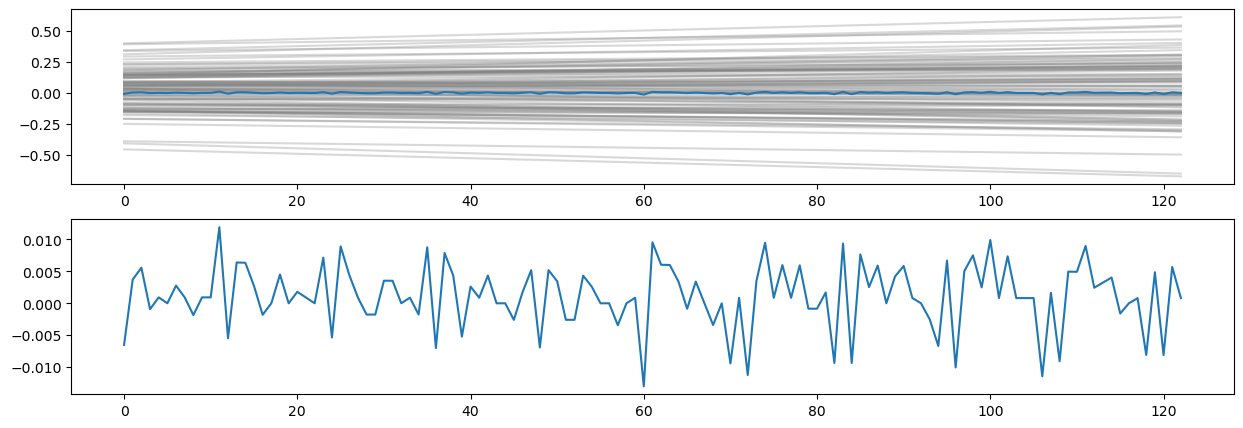

In [25]:
samp = linear_prior_predictive.prior

fig, ax = plt.subplots(2,1, figsize=(15,5))
ax[0].plot(
    samp['alpha'].values + t.reshape(len(t),1) @ samp['beta'].values + samp['sigma'].values,
    alpha=.3, color='grey'
)
ax[0].plot(y)
ax[1].plot(y);

In [26]:
with linear:
    linear_posterior_sample = pm.sample(return_inferencedata=True)
    linear_posterior_predictive = pm.sample_posterior_predictive(linear_posterior_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
Sampling: [likelihood]


''

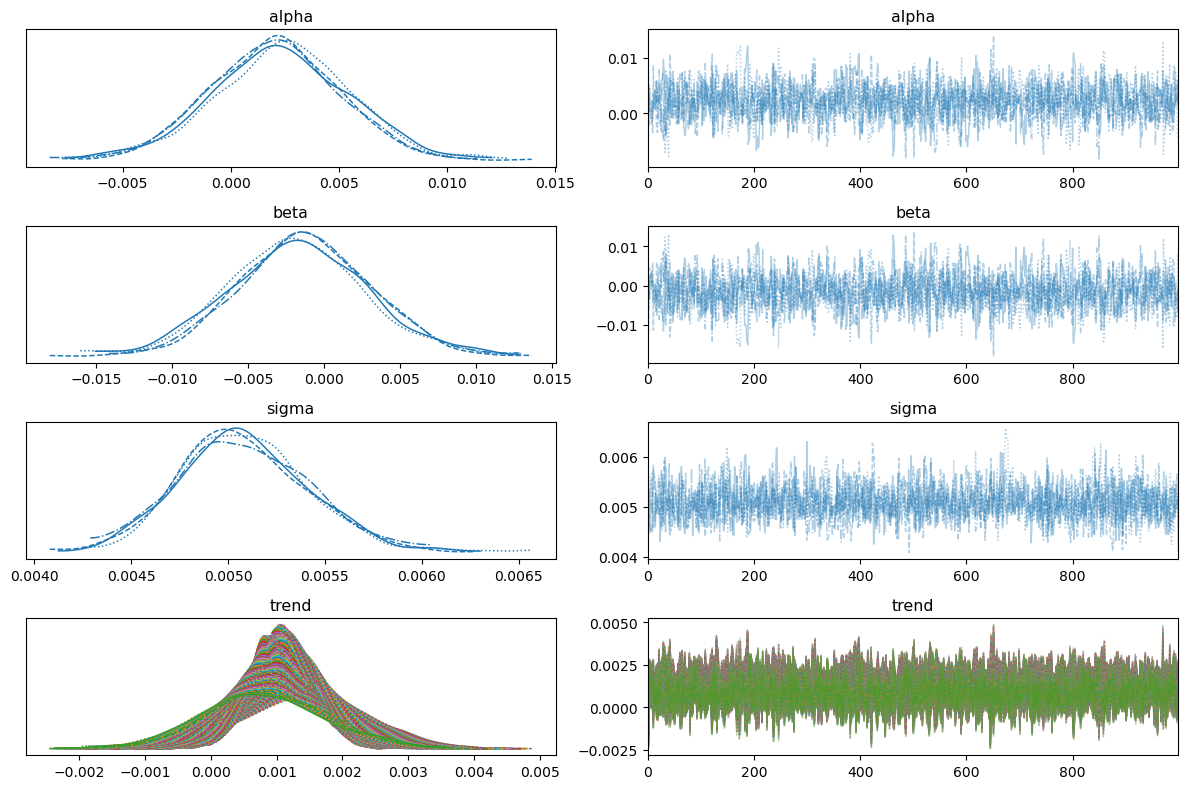

In [29]:
az.plot_trace(linear_posterior_sample)
plt.tight_layout();

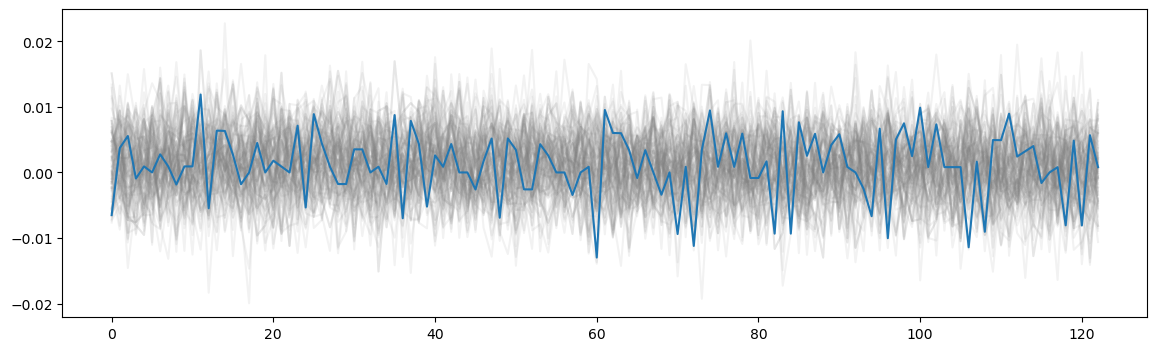

In [30]:
fig = plt.figure(figsize=(14,4))
plt.plot(
    linear_posterior_predictive.posterior_predictive['likelihood'][0, get_samp(1_000, 100), :].values.T,
    alpha=.1, 
    color='grey'
)
plt.plot(y);

In [31]:
# linear and AR

In [38]:
n_lags = 1
with pm.Model() as ar_lin:
    alpha = pm.Normal("alpha", mu=0, sigma=0.01)
    beta = pm.Normal("beta", mu=0, sigma=0.01)
    
    rho = pm.Normal("rho", mu=0, sigma=.05, shape=n_lags)
    sigma = pm.HalfNormal("sigma", sigma=0.05)
        
    trend = pm.Deterministic("trend", alpha + t[:-n_lags] * beta)
    mu = pm.Deterministic("mu", trend + y[n_lags:, None] @ rho)

    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y[:-n_lags])

    ar_lin_prior_pred = pm.sample_prior_predictive(samples=100)

Sampling: [alpha, beta, likelihood, rho, sigma]


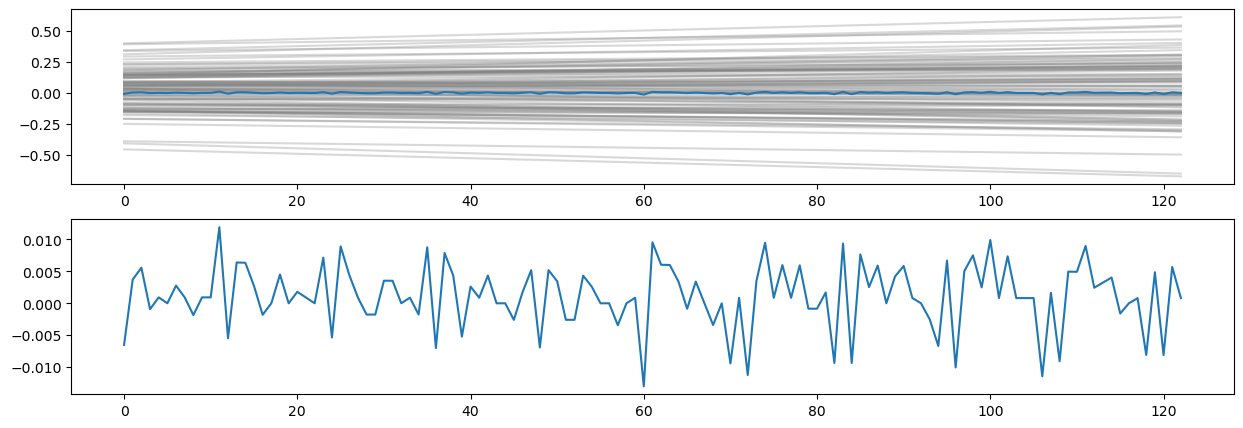

In [40]:
samp = linear_prior_predictive.prior

fig, ax = plt.subplots(2,1, figsize=(15,5))
ax[0].plot(
    samp['alpha'].values + t.reshape(len(t),1) @ samp['beta'].values + samp['sigma'].values,
    alpha=.3, color='grey'
)
ax[0].plot(y)
ax[1].plot(y);

In [44]:
with ar_lin:
    ar_lin_post = pm.sample(return_inferencedata=True)
    ar_lin_post_pred = pm.sample_posterior_predictive(ar_lin_post)

Sampling: [likelihood]


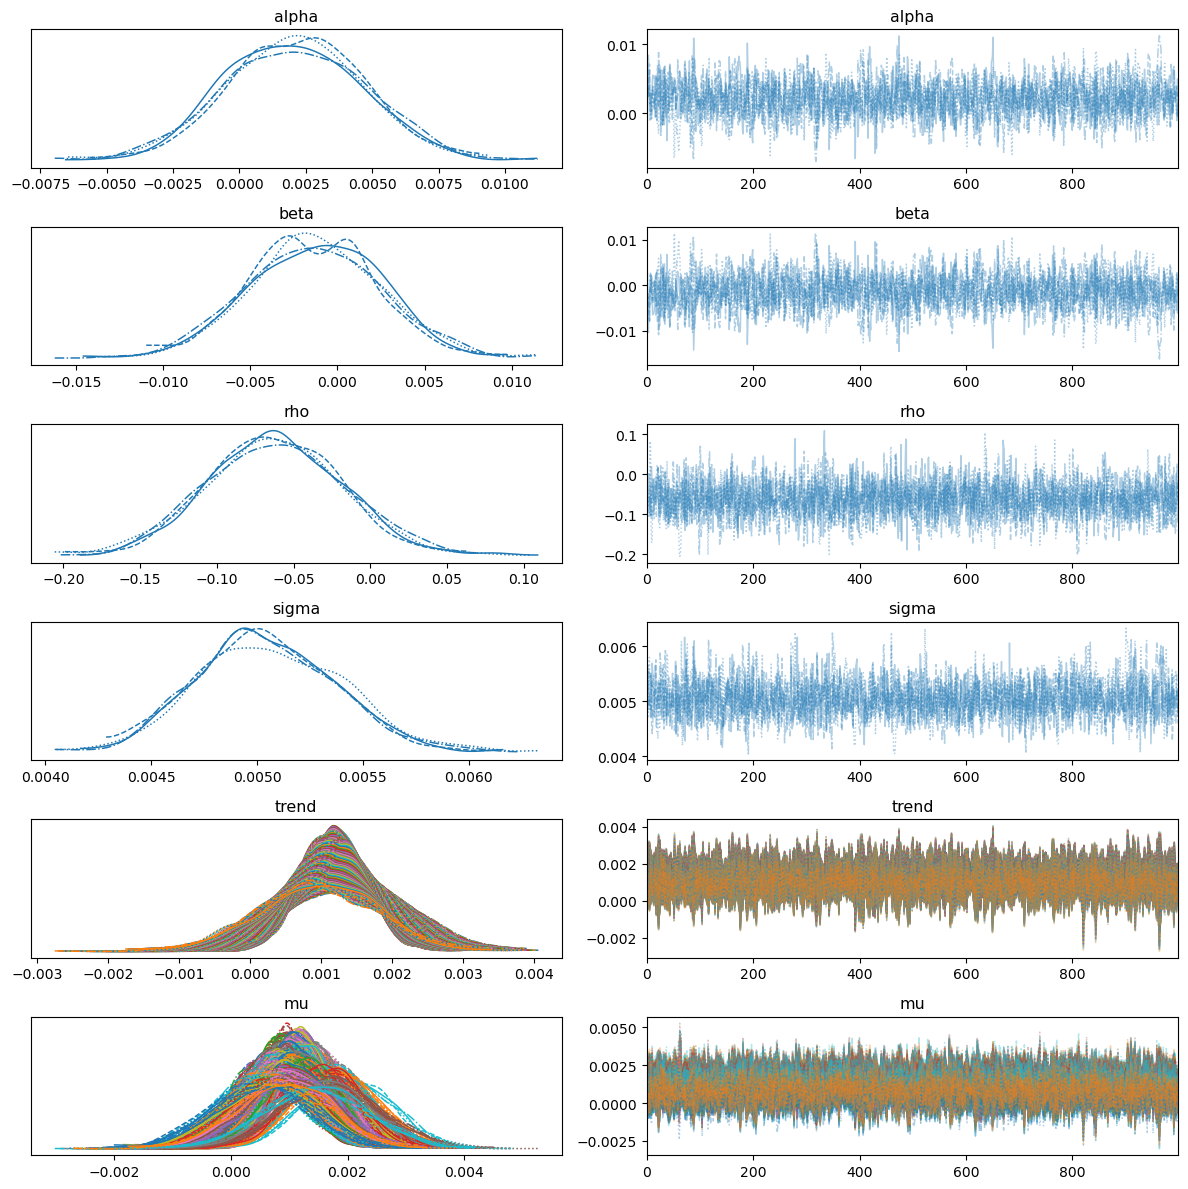

In [45]:
az.plot_trace(ar_lin_post)
plt.tight_layout();

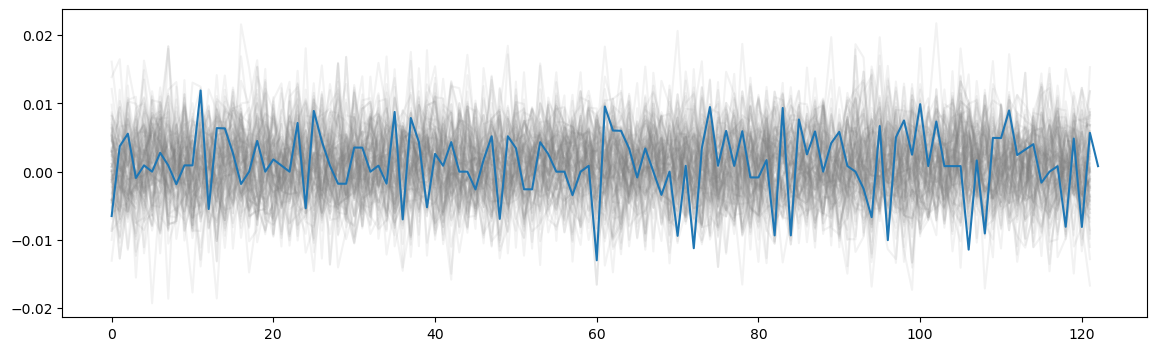

In [48]:
fig = plt.figure(figsize=(14,4))
plt.plot(
    ar_lin_post_pred.posterior_predictive['likelihood'][0, get_samp(1_000, 100), :].values.T,
    alpha=.1, 
    color='grey'
)
plt.plot(y);

In [13]:
# seasonal

In [14]:
n_order = 10
periods = _train.reset_index()['date'].dropna().dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

periods = _test.reset_index()['date'].dropna().dt.dayofyear / 365.25
fourier_features_test = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
# fourier_features

In [15]:
from src.pymc_modelling import get_VAR_arr

In [16]:
n_lags = 4

y_lag = get_VAR_arr(y[:,None], n_lags)

coords = {"fourier_features": np.arange(2 * n_order), "n_lags": range(0, n_lags)}
with pm.Model(check_bounds=False, coords=coords) as ar_lin_seas:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    
    rho = pm.Beta('rho', mu=.22, sigma=.11, shape=(n_lags,))
    beta_f = pm.Normal("beta_f", mu=1, sigma=10, dims="fourier_features")
    
    seasonality = pm.Deterministic("seasonality", pm.math.dot(beta_f, fourier_features.iloc[:-n_lags].to_numpy().T))
    trend = pm.Deterministic("trend", alpha + t[:-n_lags] * beta)
    ar_p = pm.Deterministic("AR", y_lag @ rho)
    mu = trend * (1 + seasonality) + ar_p
        
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y[:-n_lags])

    ar_lin_seas_prior = pm.sample_prior_predictive()

Sampling: [alpha, beta, beta_f, likelihood, rho, sigma]


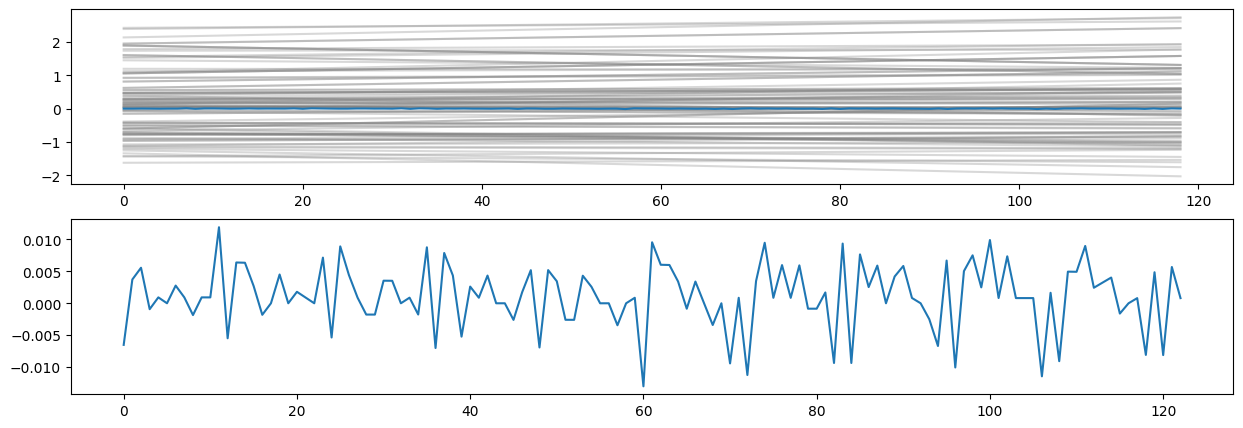

In [17]:
fig, ax = plt.subplots(2,1, figsize=(15,5))
ax[0].plot(
    ar_lin_seas_prior.prior['trend'][0, get_samp(200)].T,
    alpha=.3, color='grey'
)
ax[0].plot(y[n_lags:])
ax[1].plot(y);

In [18]:
with ar_lin_seas:
    ar_lin_seas_post = pm.sample(return_inferencedata=True)
    ar_lin_seas_post_pred = pm.sample_posterior_predictive(ar_lin_seas_post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, rho, beta_f]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


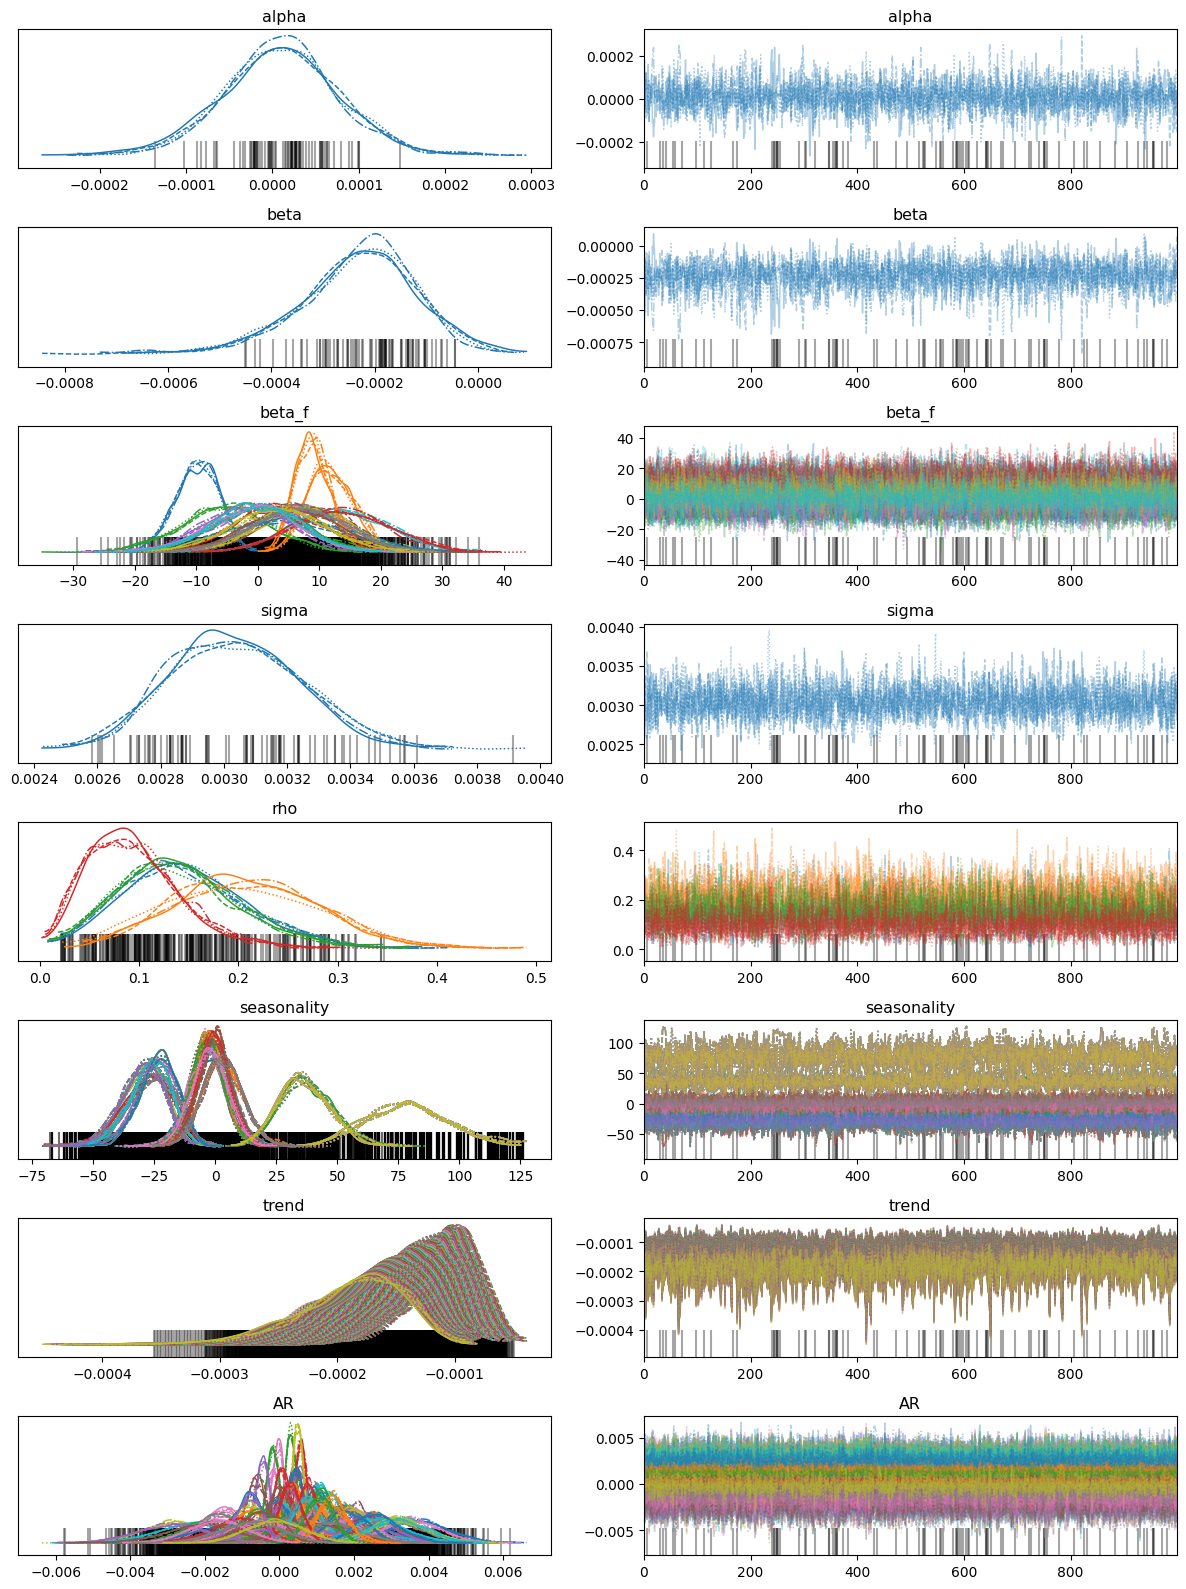

In [19]:
az.plot_trace(ar_lin_seas_post)
plt.tight_layout();

''

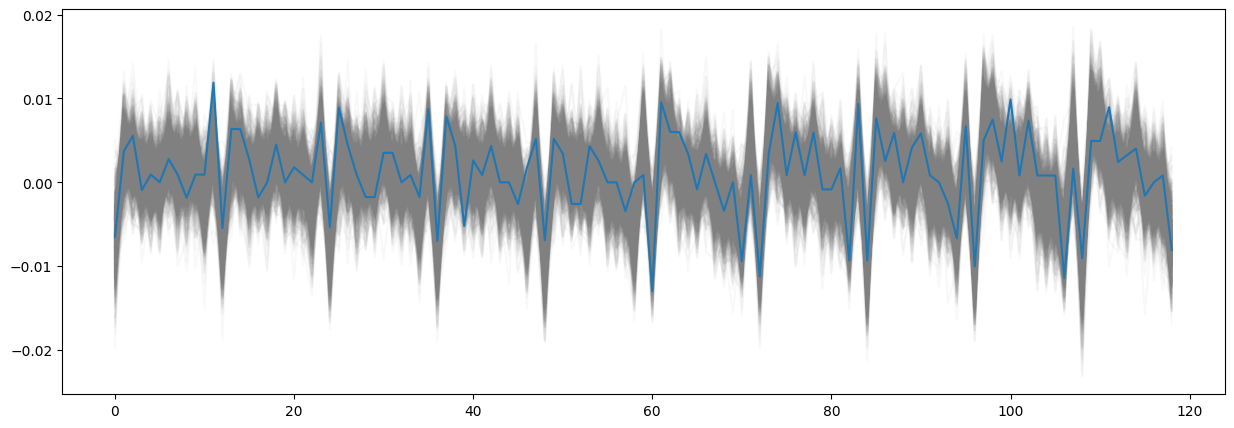

In [20]:
fig = plt.figure(figsize=(15,5))
plt.plot(
    ar_lin_seas_post_pred.posterior_predictive['likelihood'][0].T, #.mean(axis=0), 
    alpha=.05, 
    color='grey'
)
plt.plot(y[:-n_lags]);
;

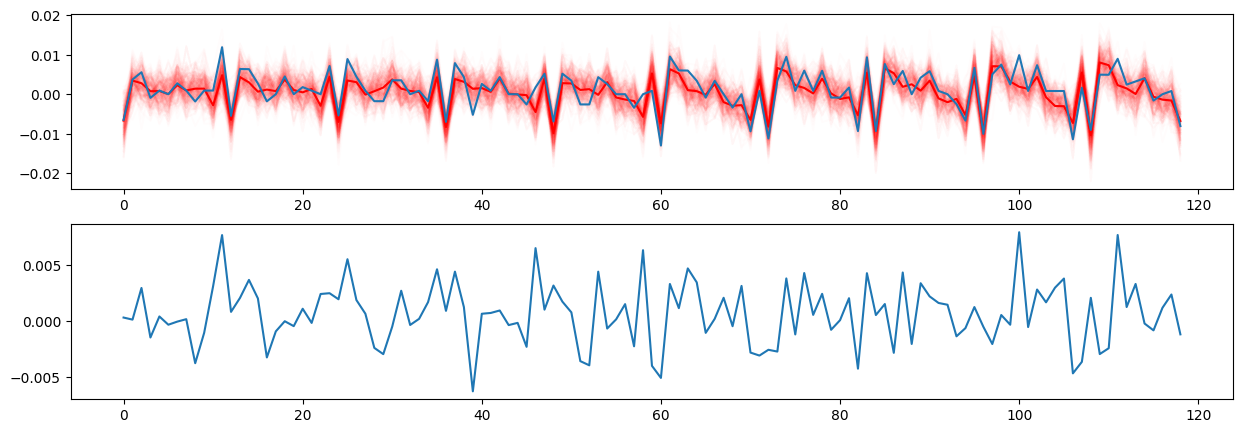

In [159]:
samp = ar_lin_seas_post_pred.posterior_predictive['likelihood']
resid = (y[:-n_lags] - samp[0, get_samp(1_000, 200), :].T.median(axis=1)).values

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].plot(
    samp[0, get_samp(1_000, 300), :].T,
    alpha=.01, 
    color='red'
)
ax[0].plot(
    samp[0, get_samp(1_000, 200), :].T.median(axis=1),
    color='red',
)
ax[0].plot(y[:-n_lags])
ax[1].plot(resid);

In [160]:
# forecast

In [161]:
samp = ar_lin_seas_post.posterior

In [162]:
trend = samp['alpha'][:, get_samp(1_000, 100)].values.ravel()[None] \
        + t_test[:,None] @ samp['beta'][:, get_samp(1_000, 100)].values.ravel()[None]

ar = get_VAR_arr(y_all[:, None], n_lags)[-len(t_test):] @ samp['rho'][:, get_samp(1_000, 100)].values.reshape(400, n_lags).T
season = (samp['beta_f'].values[:, get_samp(1_000, 100)].reshape(400, 20) @ fourier_features_test.to_numpy().T).T

forecast = trend * (1 + season) + ar
resid_test = y_test - forecast.mean(axis=1)

In [163]:
# trend = samp['alpha'][:, get_samp(1_000, 100)].values.ravel()[None] + \
#             t_test.reshape(len(t_test), 1) @ samp['beta'][:, get_samp(1_000, 100)].values.ravel()[None]
# # ar = 
# # season = (samp['beta_f'].values[:, get_samp(1_000, 100)].reshape(400, 20) @ fourier_features_test.to_numpy().T).T
# # forecast = trend * (1 + season)
# forecast = trend

# resid_test = y_test - forecast.mean(1)

In [164]:
# nice plot

In [165]:
samp = ar_lin_seas_post_pred.posterior_predictive['likelihood']

data_mod = samp[:, get_samp(1_000, 100), :].values.reshape(400, len(y)-n_lags)
data_forecast = np.concatenate([np.zeros((400, len(y)-n_lags)) * np.nan, forecast.T], axis=1)

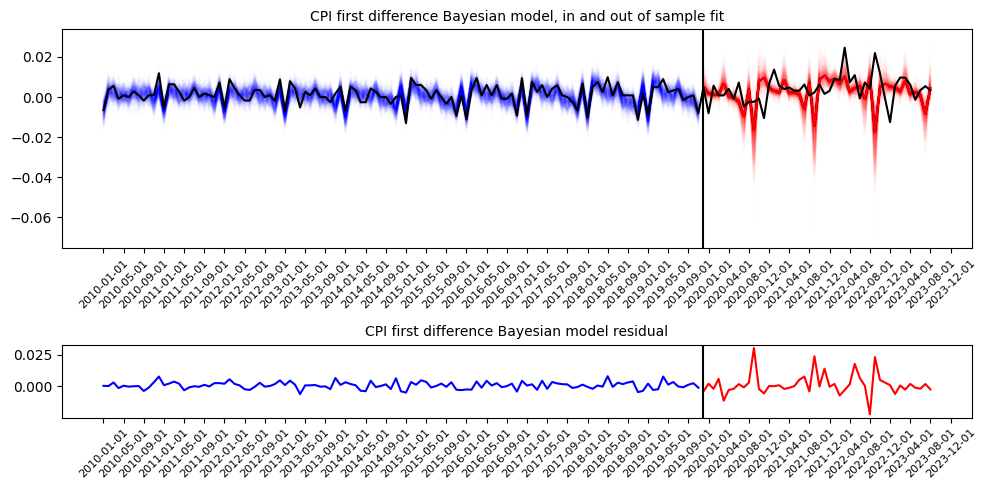

In [166]:
fig, ax = plt.subplots(2,1, figsize=(10,5), gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(data_mod.T, alpha=.0075, color='blue')
ax[0].plot(data_forecast.T.mean(axis=1), color='blue')

ax[0].plot(data_forecast.T, alpha=.0075, color='red')
ax[0].plot(data_forecast.T.mean(axis=1), color='red')

ax[0].plot(y_all[:-n_lags], color='black')

ax[1].plot(resid, color='blue')
ax[1].plot(np.concatenate([np.zeros(len(y[:-n_lags])) * np.nan, resid_test]), color='red')

ax[1].plot()

ax[0].axvline(len(y[:-n_lags]), color='black')
ax[1].axvline(len(y[:-n_lags]), color='black')

ax[0].set_title('CPI first difference Bayesian model, in and out of sample fit', size=10)
ax[1].set_title('CPI first difference Bayesian model residual', size=10)

idx = [*chain(list(_train.index), list(_test.index))]

ax[0].set_xticks([*range(0, len(idx))][0::4])
ax[0].set_xticklabels([i.date() for i in idx][0::4], rotation=45, size=8)

ax[1].set_xticks([*range(0, len(idx))][0::4])
ax[1].set_xticklabels([i.date() for i in idx][0::4], rotation=45, size=8)


plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph1.png'));

''

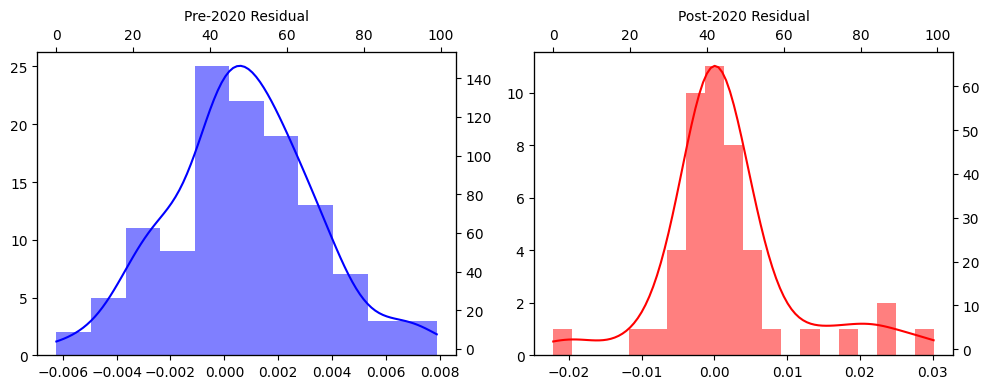

In [167]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].hist(resid, bins='fd', density=False, label='pre-2020', alpha=.5, color='blue', )
ax[0].twiny().twinx().plot([scipy.stats.gaussian_kde(resid).pdf(i) for i in np.linspace(*ax[0].get_xlim(), 100)], color='blue')

ax[1].hist(resid_test, bins='fd', density=False, label='pos-2020', alpha=.5, color='red')
ax[1].twiny().twinx().plot([scipy.stats.gaussian_kde(resid_test).pdf(i) for i in np.linspace(*ax[1].get_xlim(), 100)], color='red')

ax[0].set_title(f'Pre-2020 Residual', size=10)
ax[1].set_title(f'Post-2020 Residual', size=10)

plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph2.png'))

;

In [168]:
# merge data

In [169]:
_train['is_train'] = np.zeros(len(_train)) + True
_test['is_train'] = np.zeros(len(_test)) + False

df = pd.concat([_train, _test], axis=0).copy()
df = df.iloc[:-1]
df['is_train'] = df.is_train.astype(bool)

df['pi_de_surprise'] = np.concatenate([np.ones(n_lags-1) * np.nan, resid, resid_test])

arr = np.concatenate(
    [
        np.ones(n_lags-1) * np.nan,
        ar_lin_seas_post_pred.posterior_predictive.likelihood.values[:, get_samp(1_000, 100)].mean(axis=(0,1)),
        forecast.mean(axis=1)
    ]
)

df['pi_de_estimate'] = arr
df.drop('t', axis=1, inplace=True)

In [170]:
# annual inflation

In [171]:
# get annual inflation
df = df.join(
    df[['pi_de', 'pi_de_estimate', 'pi_de_surprise']].rolling(12).apply(lambda x: np.prod(x + 1) - 1).add_suffix('_Y')
)

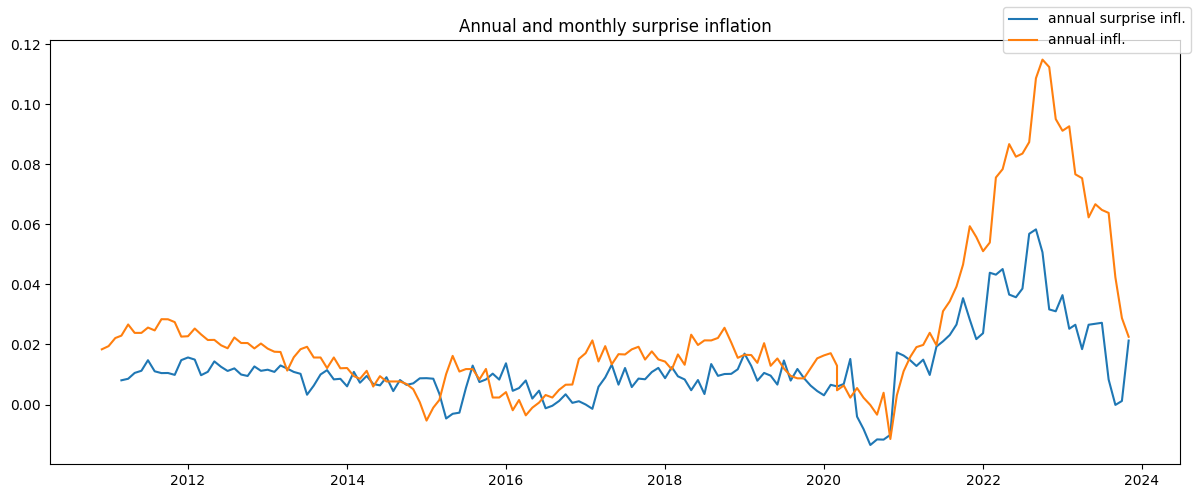

In [186]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(df.pi_de_surprise_Y, label='annual surprise infl.')
ax.plot(df.pi_de_Y, label='annual infl.')
# ax.plot(df.pi_de_surprise, label='monthly surprise infl.')
# ax.plot(df.pi_de_Y, label='realised infl.')

fig.legend()
ax.set_title('Annual and monthly surprise inflation')

plt.tight_layout()

fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_surp_infl.png'))

# diff pi

In [2]:
%run init_notebook.py

In [28]:
from src.utils import load_pd_df, get_dt_index, Capturing, save_pd_df

In [31]:
df = get_dt_index(load_pd_df('de_inf_prepro.csv'))

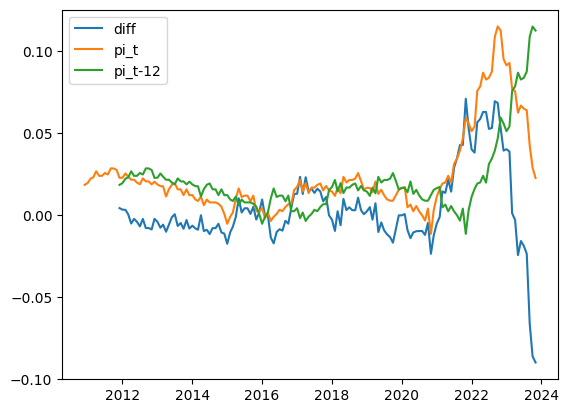

In [32]:
sub = df[['pi_de_Y']].reset_index().copy().dropna()
sub = sub.groupby('date').last().asfreq('MS')
# plt.plot(sub.shift(-12))
plt.plot(sub - sub.shift(12), label='diff')
plt.plot(sub, label='pi_t')
plt.plot(sub.shift(12), label='pi_t-12')
plt.legend()

sub['pi_de_Y_diff'] = sub - sub.shift(12)
df = df.join(sub.pi_de_Y_diff)

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest, ttest_1samp

In [26]:
acorr_ljungbox(df[~df.is_train].dropna().pi_de_surprise)

lb_stat  lb_pvalue
1  1.125516   0.288734
2  1.126031   0.569489
3  3.112719   0.374570
4  3.186170   0.527168
5  3.186191   0.671306
6  3.616272   0.728441
7  3.644449   0.819697
8  3.683759   0.884470
9  4.046797   0.908306

In [27]:
with Capturing(file_name='infl_ljunbox.txt') as output:
    for p, r in zip(["2010-01-01 to 2020-03-01", "2020-03-01 to 2023-09-01"], [resid, resid_test]):
        print("\n" + "-" * 50)
        print(f"Period: {p}")

        print("\nLjung Box test for residual autocorrelation: H0 data is indipendently distributed")
        print(acorr_ljungbox(r, boxpierce=True, model_df=1))

        print(f"\nTest for normality: H0 residual follows a normal distribution")
        [print(*i) for i in zip(['stats:', 'pval:'], [*normaltest(r)])];
    
        print(f"\nT-test: H0 the resiudal mean is different from zero")
        [print(*i) for i in zip(['stats:', 'pval:'], [*ttest_1samp(r, 0)])]
;

NameError: name 'resid' is not defined

In [24]:
[print(i) for i in output];

NameError: name 'output' is not defined

In [29]:
save_pd_df(df, "pi.feather")

In [185]:
df.to_csv(os.path.join(DATA_DIR, 'de_inf_prepro.csv'))